In [ ]:
'''
This notebook is used to generate embedding adaptors to allow the retrieval of documents to be more relevant to the queries.

Context:
Too often, queries return semantically similar results but don’t answer the question posed. 
They may also return irrelevant material which can distract the LLM from the correct results. 

Potential solution:
Training and utilizing Embedding Adapters - Adding an adapter layer to reshape embeddings 
can improve retrieval by emphasizing elements relevant to your application.

Procedure:
- load in dataset of query examples
- generate additional queries using LLM to get a larger dataset of queries
- use the dataset of queries to retrieve all the documents (i.e 1 query to 4 retrieved documents)
- label '1' for relevant document and '-1' for irrelevant document for each query (use LLM to label)
- train the embedding adaptor to learn what documents are relevant for each query, given our training dataset

The end product is an embedding adaptor that ensures queries "adapt" to the context of the documents stored.
Example: "What can I do to help my grandfather?" -> documents that provide elderly care instead of finding documents that contain the word "grandfather"
'''

In [9]:
! pip install -q google-cloud-discoveryengine
! pip install -q -U google-cloud-aiplatform
! pip install -q langchain-core
! pip install -q langchain
! pip install -q tiktoken
! pip install -q faiss-cpu

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [7]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

In [8]:
from langchain.chat_models.vertexai import ChatVertexAI
from langchain.vectorstores import MatchingEngine
from langchain.embeddings import VertexAIEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate, PromptTemplate, FewShotChatMessagePromptTemplate, ChatMessagePromptTemplate
from langchain.llms import VertexAI
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.schema import format_document
from langchain.text_splitter import CharacterTextSplitter

import vertexai
from vertexai.preview.generative_models import GenerativeModel, ChatSession
from vertexai.preview.language_models import TextGenerationModel

import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import umap
from typing import List
from pydantic import BaseModel
import matplotlib.pyplot as plt
import time
import pickle

PROJECT_ID="engaged-domain-403109"
REGION="asia-southeast1"
GCS_BUCKET="engaged-domain-403109-me-bucket"
ME_INDEX_ID="projects/510519063638/locations/asia-southeast1/indexes/4693366538231611392"
ME_ENDPOINT_ID="projects/510519063638/locations/asia-southeast1/indexEndpoints/3617586769429528576"

QUERY_EXAMPLES_FILENAME = 'data/embedding_adapter_training/query_examples.csv'

ImportError: cannot import name 'resource_pool_utils' from 'google.cloud.aiplatform.preview' (unknown location)

# Initalise embeddings object, LLM and load vector store

In [3]:
# Initialise embedding object
embeddings = VertexAIEmbeddings(location=REGION, model_name="textembedding-gecko@001")

# Load matching engine
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=GCS_BUCKET,
    embedding=embeddings,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_ENDPOINT_ID,
)

# Get retriever from matching engine
NUMBER_OF_RESULTS = 4
retriever = me.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": NUMBER_OF_RESULTS,
        },
    )

# initialise LLM
model = ChatVertexAI(model_name="chat-bison-32k",temperature=0, verbose=True, max_tokens=32768)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.vertexai.VertexAIEmbeddings` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAIEmbeddings`.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.vertexai.ChatVertexAI` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import ChatVertexAI`.
  wa

# Create QA retrieval chain

In [4]:
# create QA retriever
qa = RetrievalQA.from_chain_type(
    llm=model,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
)

# Generate query examples using LLM

In [5]:
# Load query examples dataset
query_examples_df = pd.read_csv(QUERY_EXAMPLES_FILENAME)
query_examples_df.head(15)

,S/N,Category,Example questions
0,1,General,What kind of support can I get?
1,2,General,Tell me about grants available to support care...
2,3,General,Details on home modification grants available
3,4,General,Who can I talk to to start applying for grants?
4,5,General,Is there support for seniors?
5,6,General,Tell me about support for the physically disab...
6,7,General,What support is there for special needs childr...
7,8,General,How can I get cash benefits?
8,9,General,What subsidies are available?
9,10,General,Can I get support for hiring a helper?


In [6]:
def generate_queries(model, query_example):
    # System template to provide context to LLM
    system =   """
    You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. 
    You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. 
    You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
    As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, 
    and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 

    Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. 
    Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms.
    """
    human = f"""Based on this query: \"{query_example}\", suggest 2 additional short queries that are semantically similar to this query.
    Do not output any compound questions (questions with multiple sentences or conjunctions).
    Only output the additional queries in a Python list and remove any text outside of the list.
    Query Example: "what are the financial schemes available for my grandfather"
    Output example: ["What financial support is available for my grandfather?", "Are there any financial schemes that can help my grandfather?"]"""
    
    
    # create prompt
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
    
    # create chain
    chain = prompt | model
    
    # invoke model with prompt
    output_text = chain.invoke({}).content
    
    # find list in text
    output_text = re.findall('\[.+\]', output_text)[0].strip('][')
    
    # return output as a list
    output_lst = []
    sentence = ''
    for char in output_text:
        
        # append first sentence
        if sentence.count('"') == 2:
            # remove quotation marks
            sentence = sentence[1:-1]
            
            # append sentence to list
            output_lst.append(sentence)
            
            # reset sentence variable
            sentence = ''
        sentence += char
        
    # append second sentence (exclude comma, whitespace and redundant quotation mark at the front)
    output_lst.append(sentence[3:-1])
        
    return output_lst

query_example = 'are there schemes for my grandma'
generate_queries(model, query_example)

['What are the schemes available for my grandmother?',
 'Are there any schemes that can help my grandmother?']

In [7]:
# Generate query for each query example
lst_query_examples = query_examples_df['Example questions'].to_list()
lst_llm_queries = []
for query_example in tqdm(lst_query_examples):
    lst_llm_queries.append(generate_queries(model, query_example))

lst_llm_queries

100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


[['What kind of help can I receive?',
  'Can you suggest some support options for me?'],
 ['What financial assistance can I get as a caregiver?',
  'Can you recommend any financial grants for caregivers?'],
 ['Can you tell me about home modification grants?',
  'What are the home modification grants available?'],
 ['Can you tell me who can help me apply for grants?',
  'Who can assist me in applying for grants?'],
 ['Is there any financial assistance for the elderly?',
  'What kind of support is available for seniors?'],
 ['What kind of support is available for the physically disabled?',
  'Can you provide information on support for the physically disabled?'],
 ['What kind of support is available for children with special needs?',
  'Can you suggest any support for special needs children?'],
 ['Can I get money to help me?', 'Are there any cash benefits available?'],
 ['What are the subsidies available for my grandfather?',
  'Are there any subsidies that can help my grandfather?'],
 ['

In [8]:
# Store LLM-generated questions
query_examples_df['LLM Generated Questions'] = lst_llm_queries
query_examples_df

,S/N,Category,Example questions,LLM Generated Questions
0,1,General,What kind of support can I get?,"[What kind of help can I receive?, Can you sug..."
1,2,General,Tell me about grants available to support care...,[What financial assistance can I get as a care...
2,3,General,Details on home modification grants available,[Can you tell me about home modification grant...
3,4,General,Who can I talk to to start applying for grants?,[Can you tell me who can help me apply for gra...
4,5,General,Is there support for seniors?,[Is there any financial assistance for the eld...
5,6,General,Tell me about support for the physically disab...,[What kind of support is available for the phy...
6,7,General,What support is there for special needs childr...,[What kind of support is available for childre...
7,8,General,How can I get cash benefits?,"[Can I get money to help me?, Are there any ca..."
8,9,General,What subsidies are available?,[What are the subsidies available for my grand...
9,10,General,Can I get support for hiring a helper?,"[Can I get financial help to hire a helper?, A..."


In [9]:
# Save query examples dataframe
query_examples_df.to_csv('data/embedding_adapter_training/query_examples_w_llm_queries.csv', index = False)

# Create new dataframe to store query-document pairs

In [10]:
# Transform list of list into a list
lst_complete_llm_queries = []
for query1, query2 in lst_llm_queries:
    lst_complete_llm_queries.append(query1)
    lst_complete_llm_queries.append(query2)

# Combine all queries into a list
lst_query_examples.extend(lst_complete_llm_queries)

# Create dataframe
query_doc_df = pd.DataFrame(data = {'query': lst_query_examples})

query_doc_df

,query
0,What kind of support can I get?
1,Tell me about grants available to support care...
2,Details on home modification grants available
3,Who can I talk to to start applying for grants?
4,Is there support for seniors?
...,...
175,Are there any grants to help me hire a helper?
176,Can I get financial help for a wheelchair?
177,Can I get funding for a wheelchair?
178,What are the available options for my grandmot...


# Retrieve documents for each query example

In [11]:
SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 

Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""


doc_json = qa({'query': 'what is sped?', 'context': SYSTEM_TEMPLATE})
doc_json['source_documents']

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='\uf0da Special Education Needs (SEN) Fund\n\n\uf0da Enhancement for Active Seniors (EASE)\n\nFinancial Planning and Others\n\n\uf0da Trusts\n\n\uf0da Insurance\n\n\uf0da Others\n\nSite Map\n\nTerms Of Use\n\nPrivacy Policy\n\neAdmin Singpass Login (for Individual users)\n\neAdmin Singpass Login (for Business users)\n\nSSNet – Enabling Services (for Business users)\n\nRate Our Website\n\n© 2023 Enabling Guide. All Rights Reserved.\n\nPowered by'),
 Document(page_content='3\n\nhttps://www.enablingguide.sg/docs/default-source/publications/education-pathways-for-children-with-sen-entering-sped-schools.pdf?sfvrsn=ea3b2a7e_4\n\n4\n\nhttps://www.moe.gov.sg/news/parliamentary-replies/20190211-allied-educators\n\n5\n\nhttps://www.moe.gov.sg/-/media/\x00les/special-education/parents-guide-children-special-educational-needs.ashx\n\n6\n\nhttps://www.moe.gov.sg/-/media/\x00les/special-education/parents-guide-children-special-educational-needs.ashx\n\n7\n\nhttps://www.moe.gov

In [12]:
def retrieve_docs_with_query(lst_queries: list) -> list:
    '''
    Function to retrieve source documents based on query.
    '''
    
    SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
    As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 
    
    Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""
    
    lst_retrieved_docs = []
    for query in tqdm(lst_queries):
        # Initialise list for each query
        lst_query_specific_docs = []
        
        # Retrieve source documents based on query
        source_docs = qa({'query': query, 'context': SYSTEM_TEMPLATE})['source_documents']
        
        # Store each source document
        for doc in source_docs:
            # Get the string text from document object and append to list
            lst_query_specific_docs.append(doc.page_content)
        
        # Store list into final list
        lst_retrieved_docs.append(lst_query_specific_docs)
    
    return lst_retrieved_docs

lst_retrieved_docs = retrieve_docs_with_query(query_doc_df['query'].to_list())
print(len(lst_retrieved_docs))

100%|██████████| 180/180 [09:50<00:00,  3.28s/it]

180


In [13]:
def create_query_doc_pair_df(lst_retrieved_docs: list, query_doc_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Function to store each retrieved document to its respective query.
    '''

    # Duplicate dataframe to store docs
    query_doc_df = query_doc_df.copy()
    
    # Store list of lists in a separate column
    query_doc_df['retrieved_document'] = lst_retrieved_docs
    
    # Explode 'retrieved_document' column
    query_doc_df = query_doc_df.explode('retrieved_document')
    
    # Reset index
    query_doc_df.reset_index(inplace = True, drop = True)
    
    return query_doc_df

query_doc_pair_df = create_query_doc_pair_df(lst_retrieved_docs, query_doc_df)

# Save out query-doc pair dataframe
# query_doc_pair_df.to_csv('data/embedding_adapter_training/queries_and_retrieved_docs.csv', index = False)
query_doc_pair_df.head(10)

,query,retrieved_document
0,What kind of support can I get?,"available to you, to better support you in you..."
1,What kind of support can I get?,Click here (https://www.enablingguide.sg/im-lo...
2,What kind of support can I get?,Other support provided by IHLs include barrier...
3,What kind of support can I get?,"In the event that we will need to contact you,..."
4,Tell me about grants available to support care...,around\n\nLearn more about the Home Caregiving...
5,Tell me about grants available to support care...,mentioned that they need ﬁnancial assistance o...
6,Tell me about grants available to support care...,Contact Us (https://www.aic.sg/about- us/conta...
7,Tell me about grants available to support care...,This grant gives a $250 or $400 monthly cash p...
8,Details on home modification grants available,Common modi cations include installing grab ba...
9,Details on home modification grants available,Contact Us (https://www.aic.sg/about- us/conta...


In [14]:
def store_docs_in_df(lst_retrieved_docs: list, query_doc_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Stores retrieved documents for each query in the same row for easy reference.
    '''
    
    # Duplicate dataframe to store docs
    query_doc_ref_df = query_doc_df.copy()
    
    # Initialise empty list to store lists of docs according to column index
    lst_of_lst = []
    
    for i in range(NUMBER_OF_RESULTS):
        # Initialise empty columns to store docs
        query_doc_ref_df[f'retrieved_doc_{i+1}'] = [np.nan]*len(lst_retrieved_docs)
        
        # Store empty list
        lst_of_lst.append([])
    
    # Arrange retrieved documents according to their index
    for lst_docs in tqdm(lst_retrieved_docs):
        for index in range(NUMBER_OF_RESULTS):
            # Store each document according to its index
            lst_indexed_doc = lst_of_lst[index]
            lst_indexed_doc.append(lst_docs[index])
    
    # Store each list of docs into their respective columns
    for index in range(NUMBER_OF_RESULTS):
        lst_indexed_docs = lst_of_lst[index]
        query_doc_ref_df[f'retrieved_doc_{index+1}'] = lst_indexed_docs
    
    return query_doc_ref_df
        
query_doc_ref_df = store_docs_in_df(lst_retrieved_docs, query_doc_df)
query_doc_ref_df

100%|██████████| 180/180 [00:00<00:00, 520672.22it/s]


,query,retrieved_doc_1,retrieved_doc_2,retrieved_doc_3,retrieved_doc_4
0,What kind of support can I get?,"available to you, to better support you in you...",Click here (https://www.enablingguide.sg/im-lo...,Other support provided by IHLs include barrier...,"In the event that we will need to contact you,..."
1,Tell me about grants available to support care...,around\n\nLearn more about the Home Caregiving...,mentioned that they need ﬁnancial assistance o...,Contact Us (https://www.aic.sg/about- us/conta...,This grant gives a $250 or $400 monthly cash p...
2,Details on home modification grants available,Common modi cations include installing grab ba...,Contact Us (https://www.aic.sg/about- us/conta...,click here (https://www.msf.gov.sg/media-room/...,\n\nHome Caregiving Grant (HCG)\n\nMigrant Do...
3,Who can I talk to to start applying for grants?,Caregivers Training Grant (CTG) (https://www.a...,\n\nHome Caregiving Grant (HCG)\n\nMigrant Do...,2 technical and soft skills that will prepare ...,click here (https://www.msf.gov.sg/media-room/...
4,Is there support for seniors?,(https://www.aic.sg)\n\n\n\nContact Us (https...,Singaporean citizens aged 60 and above\n\nPass...,spend three years of that time disabled in som...,\n\nI am not covered under ElderShield/CareSh...
...,...,...,...,...,...
175,Are there any grants to help me hire a helper?,Caregivers Training Grant (CTG) (https://www.a...,Click here (https://www.enablingguide.sg/im-lo...,\n\nHome Caregiving Grant (HCG)\n\nMigrant Do...,EASE has proved to be very helpful for individ...
176,Can I get financial help for a wheelchair?,Taxis for users of larger wheelchairs\n\nSome ...,the purchase of assistive technology devices. ...,Click here (https://www.enablingguide.sg/im-lo...,Financial support\n\nVarious funding schemes a...
177,Can I get funding for a wheelchair?,Taxis for users of larger wheelchairs\n\nSome ...,the purchase of assistive technology devices. ...,Click here (https://www.enablingguide.sg/im-lo...,×\n\nThis site uses cookies. By continuing to ...
178,What are the available options for my grandmot...,"available to you, to better support you in you...",For adults with severe disabilities who cannot...,\n\n\n\nMediSave Care\n\n\n\nElderFund\n\nM...,ABOUT THE WRITER\n\n(/auth\n\nTan Jia Hui (/au...


# Label query-document pairs using LLM

In [15]:
def evaluate_retrieved_doc(query:str , document:str , model) -> int:
    '''
    Function to use LLM to label the relevancy of a retrieved document, given a query.
    '''
    # Initialise system template for LLM context
    SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 

Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""
    
    SYSTEM_TEMPLATE = """ Given a query, consider the following steps to determine the relevance of a document. In this process, think critically about nuances of the context and nuances of caregiver or PWD support in Singapore.
For each step, explain your thought process and tell me your finding: 
1. Begin by identifying the key words or phrases that are indicative of their information needs as a caregiver or persons with disabilities (PWD). Tell me the key words or phrases that you have identified. 
2. Consider the context of the user query and the key words you have identified, and assess how well the document aligns with the overall context of financial support schemes provided by the Singapore government for caregivers or PWDs. In your explanation, tell me what the document is about. 
3. Consider the context of the user query and the key words you have identified, and evaluate if the document provides information directly relevant to caregivers or PWDs, such as details about financial assistance, grants or support programmes. In your explanation, tell me what is directly relevant. 
4. Use inferential reasoning to determine if the document implicitly addresses aspects of caregiver support, even if not explicitly mentioned in the query. 
5. Based on the above considerations, make an overall judgment on the relevance of the document to the given query. Respond with 'yes' if the document is relevant, and 'no' if it is not."""
    
    # Format query
    query = f"""For the given query, evaluate whether the following document provides relevant context to answer the query. 
    Output only "yes" or "no".
    Query: '{query}'
    Document: {document}"""
    
    prompt = ChatPromptTemplate.from_messages([("system", SYSTEM_TEMPLATE), ("human", query)])

    # Get response
    chain = prompt | model
    response = chain.invoke({}).content
    
    # Remove whitespaces in response
    evaluation = re.sub('\s', '', response)
    
    # Label 'yes' with 1 and 'no' with -1
    if evaluation == 'yes':
        return 1
    elif evaluation == 'no':
        return -1
    
def evaluate_retrieved_doc_in_chunks(query: str, full_doc: str, model, token_chunk_size: int) -> int:
    '''
    Evaluates relevancy of retrieved document by splitting the document into smaller text chunks and evaluating them separately.
    Retrieved document is considered relevant if at least one of the smaller text chunk is relevant.
    '''
    # Initiailise text splitter object
    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=token_chunk_size, chunk_overlap=5)
    
    # Split document into smaller text chunks
    lst_split_doc = text_splitter.split_text(document)
    
    # Evaluate each text chunk
    for split_doc in lst_split_doc:
    
        # Evaluate text chunk
        eval_result = evaluate_retrieved_doc(query, split_doc, model)
        
        # End loop if text chunk is relevant
        if eval_result == 1:
            return 1
        
    return -1    

In [16]:
# Test labelling function
document = 'The Enabling Transport Subsidy supports eligible Singapore Citizens and Permanent Residents with disabilities who need to use dedicated transport provided by the Social Service Agencies (SSAs) to access the Early Intervention Programme for Infants and Children (EIPIC), Special Education (SPED) schools, Day Activity Centres (DACs), Sheltered Workshops (SWs) and Special Student Care Centres (SSCCs).\n\nThe subsidy scheme is means-tested – to be eligible, the monthly per capita household income should be $2,800 or less for Singapore citizens and $2,000 or less for Permanent Residents. People on this scheme cannot concurrently be recipients of TSS (above). Interested applicants should apply for the Enabling Transport Subsidy through their SPED school or Social Service Agencies.\n\nPrivate personal cars\n\nActions to take\n\nParticipate in the Driving Assessment and Rehabilitation Programme after obtaining a referral from your doctor.'
query = 'what is sped'
evaluate_retrieved_doc(query, document, model)

1

In [17]:
def evaluate_retrieved_doc(query:str , document:str , model) -> int:
    '''
    Function to use LLM to label the relevancy of a retrieved document, given a query.
    '''
    # Initialise system template for LLM context
    SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 

Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""
    
#     SYSTEM_TEMPLATE = """ Given a query, consider the following steps to determine the relevance of a document. In this process, think critically about nuances of the context and nuances of caregiver or PWD support in Singapore.
# For each step, explain your thought process and tell me your finding: 
# 1. Begin by identifying the key words or phrases that are indicative of their information needs as a caregiver or persons with disabilities (PWD). Tell me the key words or phrases that you have identified. 
# 2. Consider the context of the user query and the key words you have identified, and assess how well the document aligns with the overall context of financial support schemes provided by the Singapore government for caregivers or PWDs.
# 3. Consider the context of the user query and the key words you have identified, and evaluate if the document provides information directly relevant to caregivers or PWDs, such as details about financial assistance, grants or support programmes.
# 4. Use inferential reasoning to determine if the document implicitly addresses aspects of caregiver support, even if not explicitly mentioned in the query. 
# 5. Based on the above considerations, make an overall judgment on the relevance of the document to the given query."""
    
    # Format query
    query_template = f"""For the given query, evaluate whether the following retrieved document provides relevant context to answer the query. 
    Output only "yes" or "no".
    Query: '{query}'
    Retrieved Document: {document}"""
    
    prompt = SYSTEM_TEMPLATE + '\n' + query_template
    
    chat = gem_model.start_chat()
    
    # Get response
    response = chat.send_message(prompt).text
    
    # Find 'yes' or 'no' in the free text response
    evaluation_lst = re.findall(r'(no|yes)', response)
    
    # If labelled 'yes' AND 'no', consider document as relevant
    if len(evaluation_lst) == 2:
        return 1
    # If no labels, consider document as irrelevant
    elif len(evaluation_lst)==0:
        return -1
    # Get label from regex list
    evaluation = evaluation_lst[0]
    
    # Label 'yes' with 1 and 'no' with -1
    if evaluation == 'yes':
        return 1
    elif evaluation == 'no':
        return -1
    

# Initialise Gemini-Pro model
gem_model = GenerativeModel("gemini-pro")

# Get query-doc dictionary pairs
lst_records = query_doc_pair_df.to_dict('records')

# Initalise empty list to store labels
lst_labels = []
for query, retrieved_doc in tqdm(lst_records):
    lst_labels.append(evaluate_retrieved_doc(query, retrieved_doc, gem_model))

# Show labels
lst_labels[:12]

100%|██████████| 720/720 [10:04<00:00,  1.19it/s]


[1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]

In [18]:
# Store labels in query-doc pair dataframe
query_doc_pair_df['label'] = lst_labels
print(query_doc_pair_df['label'].value_counts())

# save out query-doc pair with labels dataframe
query_doc_pair_df.to_csv('data/embedding_adapter_training/labelled_query_doc_data.csv', escapechar='.', index=False)

query_doc_pair_df

label
-1    361
 1    359
Name: count, dtype: int64


,query,retrieved_document,label
0,What kind of support can I get?,"available to you, to better support you in you...",1
1,What kind of support can I get?,Click here (https://www.enablingguide.sg/im-lo...,1
2,What kind of support can I get?,Other support provided by IHLs include barrier...,1
3,What kind of support can I get?,"In the event that we will need to contact you,...",-1
4,Tell me about grants available to support care...,around\n\nLearn more about the Home Caregiving...,-1
...,...,...,...
715,What are the available options for my grandmot...,ABOUT THE WRITER\n\n(/auth\n\nTan Jia Hui (/au...,-1
716,Can you suggest some options for my grandma wh...,"available to you, to better support you in you...",1
717,Can you suggest some options for my grandma wh...,ABOUT THE WRITER\n\n(/auth\n\nTan Jia Hui (/au...,-1
718,Can you suggest some options for my grandma wh...,mentioned that they need ﬁnancial assistance o...,1


# Process data for training

In [19]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)

class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]
    
# Embeddings API integrated with langChain
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

Model_name will become a required arg for VertexAIEmbeddings starting from Feb-01-2024. Currently the default is set to textembedding-gecko@001


In [20]:
# Get query embedding function (input is a list of string texts)
embed_function = embeddings.embed_documents

# Store processed training data
adapter_query_embeddings = embed_function(query_doc_pair_df['query'].to_list())
adapter_doc_embeddings = embed_function(query_doc_pair_df['retrieved_document'].to_list())
adapter_labels = query_doc_pair_df['label'].to_list()

Waiting
...............................................................................................................................................Waiting
...............................................................................................................................................

In [21]:
# Store processed training data inside a dataframe to save
adapter_data_df = pd.DataFrame(data = {'query_embeddings': adapter_query_embeddings, 'doc_embeddings': adapter_doc_embeddings, 'label': adapter_labels})

# Save embedding adaptor training dataset
adapter_data_df.to_csv('data/embedding_adapter_training/adapter_training_data.csv', index = False)

In [7]:
adapter_data_df

,query_embeddings,doc_embeddings,label
0,"[0.02894503064453602, 0.013027781620621681, 0....","[-0.008256268687546253, -0.03230484947562218, ...",1
1,"[0.02894503064453602, 0.013027781620621681, 0....","[0.016098102554678917, -0.033040232956409454, ...",1
2,"[0.02894503064453602, 0.013027781620621681, 0....","[-0.011955850757658482, -0.0404520183801651, -...",1
3,"[0.02894503064453602, 0.013027781620621681, 0....","[0.017305046319961548, -0.04557742550969124, 0...",-1
4,"[0.027993489056825638, 0.012320282869040966, 0...","[-0.013610908761620522, -0.03402447700500488, ...",-1
...,...,...,...
715,"[0.028514647856354713, -0.006540228147059679, ...","[0.006840206682682037, -0.06978115439414978, 0...",-1
716,"[0.03631738945841789, -0.00686822272837162, 0....","[-0.008310187608003616, -0.032339952886104584,...",1
717,"[0.03631738945841789, -0.00686822272837162, 0....","[0.006840206682682037, -0.06978115439414978, 0...",-1
718,"[0.03631738945841789, -0.00686822272837162, 0....","[-0.006011872552335262, -0.031988535076379776,...",1


In [32]:
# Specify additional negative class samples to add to training
additional_sample_n = 0

# Get dataframe with rows of -1 labels, with length equal to number of positive classes (due to smaller training sample for positive class)
negative_label_df = adapter_data_df[adapter_data_df['label']==-1][50:len(adapter_data_df[adapter_data_df['label']==1])+additional_sample_n]

# Form training dataframe with equal positive and negative labels
training_data_df = pd.concat([adapter_data_df[adapter_data_df['label']==1], negative_label_df])
training_data_df.sort_index(inplace=True)


print(training_data_df['label'].value_counts())

# Get the embeddings and labels as lists
adapter_query_embeddings, adapter_doc_embeddings, adapter_labels = training_data_df['query_embeddings'].to_list(), training_data_df['doc_embeddings'].to_list(), training_data_df['label'].to_list()

label
 1    359
-1    309
Name: count, dtype: int64


# Set up model for training

In [26]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    # NOTE: with 1 & -1 values, we want the query to be in the same direction as relevant documents and opposite direction for irrelevant documents, we are training our adaptor matrix to do this
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [33]:
# Convert lists into tensors
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [34]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [35]:
# Transform into torch tensor dataset
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [36]:
# Train the embedding adapter
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(200)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)
        
        # if loss is better than previous loss, update as best matrix
        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()
        
        # back propagate (similar to training a single layer NN)
        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.1 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
            
print(f"Best loss: {min_loss.detach().numpy()}")

100%|██████████| 200/200 [02:20<00:00,  1.42it/s]

Best loss: 0.38876664638519287


In [35]:
# Train the embedding adapter
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(200)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)
        
        # if loss is better than previous loss, update as best matrix
        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()
        
        # back propagate (similar to training a single layer NN)
        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.1 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
            
print(f"Best loss: {min_loss.detach().numpy()}")

100%|██████████| 200/200 [02:21<00:00,  1.41it/s]

Best loss: 0.44446393847465515


In [37]:
# Save best matrix
import pickle

with open('data/embedding_adapter_training/adapter_matrix.pickle', 'wb') as f:
    pickle.dump(best_matrix, f)

# Show result of embedding adapter

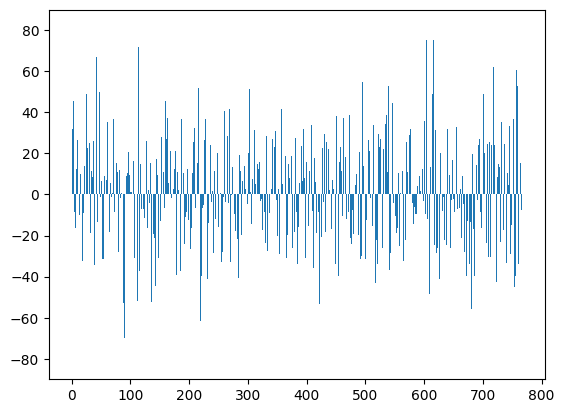

In [38]:
# Initialise test vector to see how it gets adapted with the embedding adapter
test_vector = torch.ones((mat_size,1))

# matrix multiplication between our best matrix and a test vector: 
#       we see this as stretching and squeezing spaces for the dimensions that are most relevant 
#       to particular queries that we have while reducing dimensions that are not relevant to our query
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [40]:
# Get all documents from vector store
NUMBER_OF_RESULTS = 195
lst_doc_in_vector_store = me.as_retriever(
                                search_type="similarity",
                                search_kwargs={
                                    "k": NUMBER_OF_RESULTS,
                                },
                            ).get_relevant_documents('what is sped')

# Get string of each Document object
lst_doc_in_vector_store = [doc.page_content for doc in lst_doc_in_vector_store]

embed_function = embeddings.embed_documents

# Transform document texts into embeddings
lst_doc_embeddings = embed_function(lst_doc_in_vector_store)

In [43]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

# Fit umap model (purpose is to reduce dimensionality)
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(lst_doc_embeddings)

# matrix multiply best adapted matrix and the query embeddings
adapted_query_embeddings = np.matmul(best_matrix, np.array(adapter_query_embeddings).T).T

# Get projects of all embeddings using umap model
projected_dataset_embeddings = project_embeddings(lst_doc_embeddings, umap_transform)
projected_query_embeddings = project_embeddings(adapter_query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 668/668 [11:05<00:00,  1.00it/s]


In [44]:
projected_dataset_embeddings = project_embeddings(lst_doc_embeddings, umap_transform)

100%|██████████| 195/195 [03:14<00:00,  1.00it/s]


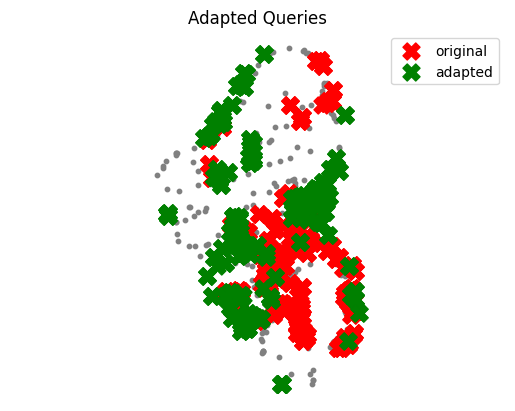

In [45]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")


# embedding adaptor pushes the queries into a particular part of the space (example of how embedding adaptors can customize query embeddings to specific application)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

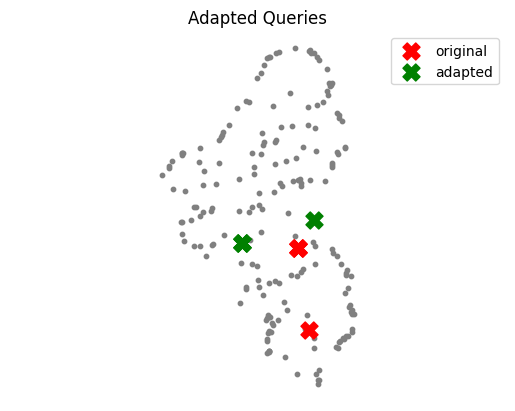

In [48]:
# Plot the projected query and retrieved documents in the embedding space
i=4 # same query for every 4 rows
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:i, 0], projected_query_embeddings[:i, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:i, 0], projected_adapted_query_embeddings[:i, 1], s=150, marker='X', color='green', label="adapted")


# embedding adaptor pushes the queries into a particular part of the space (example of how embedding adaptors can customize query embeddings to specific application)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

# Create custom Matching Engine class to integrate embedding adapter

In [8]:
# Load adapter matrix
with open('data/embedding_adapter_training/adapter_matrix.pickle', 'rb') as f:
    best_matrix = pickle.load(f)

In [3]:
import json
import logging
import time
import uuid
from typing import TYPE_CHECKING, Any, Iterable, List, Optional, Tuple, Type

from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.vectorstores import VectorStore

from langchain_community.utilities.vertexai import get_client_info


from google.cloud import storage
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint
from google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint import (
    Namespace,
)
from google.oauth2.service_account import Credentials

from langchain_community.embeddings import TensorflowHubEmbeddings
    
logger = logging.getLogger(__name__)

class CustomMatchingEngine(VectorStore):
    """`Google Vertex AI Vector Search` (previously Matching Engine) vector store.

    While the embeddings are stored in the Matching Engine, the embedded
    documents will be stored in GCS.

    An existing Index and corresponding Endpoint are preconditions for
    using this module.

    See usage in docs/integrations/vectorstores/google_vertex_ai_vector_search.ipynb

    Note that this implementation is mostly meant for reading if you are
    planning to do a real time implementation. While reading is a real time
    operation, updating the index takes close to one hour."""

    def __init__(
        self,
        project_id: str,
        index: MatchingEngineIndex,
        endpoint: MatchingEngineIndexEndpoint,
        embedding: Embeddings,
        adapted_embedding: Embeddings,
        gcs_client: storage.Client,
        gcs_bucket_name: str,
        credentials: Optional[Credentials] = None,
        *,
        document_id_key: Optional[str] = None,
    ):
        """Google Vertex AI Vector Search (previously Matching Engine)
         implementation of the vector store.

        While the embeddings are stored in the Matching Engine, the embedded
        documents will be stored in GCS.

        An existing Index and corresponding Endpoint are preconditions for
        using this module.

        See usage in
        docs/integrations/vectorstores/google_vertex_ai_vector_search.ipynb.

        Note that this implementation is mostly meant for reading if you are
        planning to do a real time implementation. While reading is a real time
        operation, updating the index takes close to one hour.

        Attributes:
            project_id: The GCS project id.
            index: The created index class. See
                ~:func:`MatchingEngine.from_components`.
            endpoint: The created endpoint class. See
                ~:func:`MatchingEngine.from_components`.
            embedding: A :class:`Embeddings` that will be used for
                embedding the text sent. If none is sent, then the
                multilingual Tensorflow Universal Sentence Encoder will be used.
            gcs_client: The GCS client.
            gcs_bucket_name: The GCS bucket name.
            credentials (Optional): Created GCP credentials.
            document_id_key (Optional): Key for storing document ID in document
                metadata. If None, document ID will not be returned in document
                metadata.
        """
        super().__init__()
        self._validate_google_libraries_installation()

        self.project_id = project_id
        self.index = index
        self.endpoint = endpoint
        self.embedding = embedding
        self.adapted_embedding = adapted_embedding
        self.gcs_client = gcs_client
        self.credentials = credentials
        self.gcs_bucket_name = gcs_bucket_name
        self.document_id_key = document_id_key

    @property
    def embeddings(self) -> Embeddings:
        return self.embedding

    def _validate_google_libraries_installation(self) -> None:
        """Validates that Google libraries that are needed are installed."""
        try:
            from google.cloud import aiplatform, storage  # noqa: F401
            from google.oauth2 import service_account  # noqa: F401
        except ImportError:
            raise ImportError(
                "You must run `pip install --upgrade "
                "google-cloud-aiplatform google-cloud-storage`"
                "to use the MatchingEngine Vectorstore."
            )
    def similarity_search_with_score(
        self,
        query: str,
        k: int = 4,
        filter: Optional[List[Namespace]] = None,
    ) -> List[Tuple[Document, float]]:
        """Return docs most similar to query and their cosine distance from the query.

        Args:
            query: String query look up documents similar to.
            k: Number of Documents to return. Defaults to 4.
            filter: Optional. A list of Namespaces for filtering
                the matching results.
                For example:
                [Namespace("color", ["red"], []), Namespace("shape", [], ["squared"])]
                will match datapoints that satisfy "red color" but not include
                datapoints with "squared shape". Please refer to
                https://cloud.google.com/vertex-ai/docs/matching-engine/filtering#json
                for more detail.

        Returns:
            List[Tuple[Document, float]]: List of documents most similar to
            the query text and cosine distance in float for each.
            Lower score represents more similarity.
        """
        logger.debug(f"Embedding query {query}.")
        embedding_query = self.adapted_embedding.embed_query(query)
        return self.similarity_search_by_vector_with_score(
            embedding_query, k=k, filter=filter
        )

    def similarity_search_by_vector_with_score(
        self,
        embedding: List[float],
        k: int = 4,
        filter: Optional[List[Namespace]] = None,
    ) -> List[Tuple[Document, float]]:
        """Return docs most similar to the embedding and their cosine distance.

        Args:
            embedding: Embedding to look up documents similar to.
            k: Number of Documents to return. Defaults to 4.
            filter: Optional. A list of Namespaces for filtering
                the matching results.
                For example:
                [Namespace("color", ["red"], []), Namespace("shape", [], ["squared"])]
                will match datapoints that satisfy "red color" but not include
                datapoints with "squared shape". Please refer to
                https://cloud.google.com/vertex-ai/docs/matching-engine/filtering#json
                for more detail.

        Returns:
            List[Tuple[Document, float]]: List of documents most similar to
            the query text and cosine distance in float for each.
            Lower score represents more similarity.

        """
        filter = filter or []

        # If the endpoint is public we use the find_neighbors function.
        if hasattr(self.endpoint, "_public_match_client") and (
            self.endpoint._public_match_client
        ):
            response = self.endpoint.find_neighbors(
                deployed_index_id=self._get_index_id(),
                queries=[embedding],
                num_neighbors=k,
                filter=filter,
            )
        else:
            response = self.endpoint.match(
                deployed_index_id=self._get_index_id(),
                queries=[embedding],
                num_neighbors=k,
                filter=filter,
            )

        # NOTE: Rerun document retrieval if documents collected is less than k 
        #       (due to current vector store having invalid document for a particular index)
        for result in response[0]:
            if result.id == '025dfeb0-0468-489c-9008-f0a5ed1d24ad':
                if hasattr(self.endpoint, "_public_match_client") and (
                    self.endpoint._public_match_client
                ):
                    response = self.endpoint.find_neighbors(
                        deployed_index_id=self._get_index_id(),
                        queries=[embedding],
                        num_neighbors=k+1,
                        filter=filter,
                    )
                else:
                    response = self.endpoint.match(
                        deployed_index_id=self._get_index_id(),
                        queries=[embedding],
                        num_neighbors=k+1,
                        filter=filter,
                    )
                break
                
        logger.debug(f"Found {len(response)} matches.")

        if len(response) == 0:
            return []

        docs: List[Tuple[Document, float]] = []
        
        # I'm only getting the first one because queries receives an array
        # and the similarity_search method only receives one query. This
        # means that the match method will always return an array with only
        # one element.
        for result in response[0]:
            try:
                page_content = self._download_from_gcs(f"documents/{result.id}")
                # TODO: return all metadata.
                metadata = {}
                if self.document_id_key is not None:
                    metadata[self.document_id_key] = result.id
                document = Document(
                    page_content=page_content,
                    metadata=metadata,
                )
                docs.append((document, result.distance))
            except Exception as e:
                # print(e)
                continue

        logger.debug("Downloaded documents for query.")

        return docs

    def _get_index_id(self) -> str:
        """Gets the correct index id for the endpoint.

        Returns:
            The index id if found (which should be found) or throws
            ValueError otherwise.
        """
        for index in self.endpoint.deployed_indexes:
            if index.index == self.index.resource_name:
                return index.id

        raise ValueError(
            f"No index with id {self.index.resource_name} "
            f"deployed on endpoint "
            f"{self.endpoint.display_name}."
        )

    def _download_from_gcs(self, gcs_location: str) -> str:
        """Downloads from GCS in text format.

        Args:
            gcs_location: The location where the file is located.

        Returns:
            The string contents of the file.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        blob = bucket.blob(gcs_location)
        return blob.download_as_string()

    @classmethod
    def from_texts(
        cls: Type["MatchingEngine"],
        texts: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`add_texts`"
        )
    def add_texts(
        self,
        texts: Iterable[str],
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Run more texts through the embeddings and add to the vectorstore.

        Args:
            texts: Iterable of strings to add to the vectorstore.
            metadatas: Optional list of metadatas associated with the texts.
            kwargs: vectorstore specific parameters.

        Returns:
            List of ids from adding the texts into the vectorstore.
        """
        texts = list(texts)
        if metadatas is not None and len(texts) != len(metadatas):
            raise ValueError(
                "texts and metadatas do not have the same length. Received "
                f"{len(texts)} texts and {len(metadatas)} metadatas."
            )
        logger.debug("Embedding documents.")
        embeddings = self.embedding.embed_documents(texts)
        jsons = []
        ids = []
        # Could be improved with async.
        for idx, (embedding, text) in enumerate(zip(embeddings, texts)):
            id = str(uuid.uuid4())
            ids.append(id)
            json_: dict = {"id": id, "embedding": embedding}
            if metadatas is not None:
                json_["metadata"] = metadatas[idx]
            jsons.append(json_)
            self._upload_to_gcs(text, f"documents/{id}")

        logger.debug(f"Uploaded {len(ids)} documents to GCS.")

        # Creating json lines from the embedded documents.
        result_str = "\n".join([json.dumps(x) for x in jsons])

        filename_prefix = f"indexes/{uuid.uuid4()}"
        filename = f"{filename_prefix}/{time.time()}.json"
        self._upload_to_gcs(result_str, filename)
        logger.debug(
            f"Uploaded updated json with embeddings to "
            f"{self.gcs_bucket_name}/{filename}."
        )

        self.index = self.index.update_embeddings(
            contents_delta_uri=f"gs://{self.gcs_bucket_name}/{filename_prefix}/"
        )

        logger.debug("Updated index with new configuration.")

        return ids
    
    def similarity_search(
        self,
        query: str,
        k: int = 4,
        filter: Optional[List[Namespace]] = None,
        **kwargs: Any,
    ) -> List[Document]:
        """Return docs most similar to query.

        Args:
            query: The string that will be used to search for similar documents.
            k: The amount of neighbors that will be retrieved.
            filter: Optional. A list of Namespaces for filtering the matching results.
                For example:
                [Namespace("color", ["red"], []), Namespace("shape", [], ["squared"])]
                will match datapoints that satisfy "red color" but not include
                datapoints with "squared shape". Please refer to
                https://cloud.google.com/vertex-ai/docs/matching-engine/filtering#json
                 for more detail.

        Returns:
            A list of k matching documents.
        """
        docs_and_scores = self.similarity_search_with_score(
            query, k=k, filter=filter, **kwargs
        )

        return [doc for doc, _ in docs_and_scores]
    
    @classmethod
    def from_components(
        cls: Type["MatchingEngine"],
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        index_id: str,
        endpoint_id: str,
        credentials_path: Optional[str] = None,
        embedding: Optional[Embeddings] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Takes the object creation out of the constructor.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: The location where the vectors will be stored in
            order for the index to be created.
            index_id: The id of the created index.
            endpoint_id: The id of the created endpoint.
            credentials_path: (Optional) The path of the Google credentials on
            the local file system.
            embedding: The :class:`Embeddings` that will be used for
            embedding the texts.
            kwargs: Additional keyword arguments to pass to MatchingEngine.__init__().

        Returns:
            A configured MatchingEngine with the texts added to the index.
        """
        gcs_bucket_name = cls._validate_gcs_bucket(gcs_bucket_name)
        credentials = cls._create_credentials_from_file(credentials_path)
        index = cls._create_index_by_id(index_id, project_id, region, credentials)
        endpoint = cls._create_endpoint_by_id(
            endpoint_id, project_id, region, credentials
        )

        gcs_client = cls._get_gcs_client(credentials, project_id)
        cls._init_aiplatform(project_id, region, gcs_bucket_name, credentials)

        return cls(
            project_id=project_id,
            index=index,
            endpoint=endpoint,
            embedding=embedding or cls._get_default_embeddings(),
            gcs_client=gcs_client,
            credentials=credentials,
            gcs_bucket_name=gcs_bucket_name,
            **kwargs,
        )
    
    @classmethod
    def _validate_gcs_bucket(cls, gcs_bucket_name: str) -> str:
        """Validates the gcs_bucket_name as a bucket name.

        Args:
              gcs_bucket_name: The received bucket uri.

        Returns:
              A valid gcs_bucket_name or throws ValueError if full path is
              provided.
        """
        gcs_bucket_name = gcs_bucket_name.replace("gs://", "")
        if "/" in gcs_bucket_name:
            raise ValueError(
                f"The argument gcs_bucket_name should only be "
                f"the bucket name. Received {gcs_bucket_name}"
            )
        return gcs_bucket_name

    @classmethod
    def _create_credentials_from_file(
        cls, json_credentials_path: Optional[str]
    ) -> Optional[Credentials]:
        """Creates credentials for GCP.

        Args:
             json_credentials_path: The path on the file system where the
             credentials are stored.

         Returns:
             An optional of Credentials or None, in which case the default
             will be used.
        """

        from google.oauth2 import service_account

        credentials = None
        if json_credentials_path is not None:
            credentials = service_account.Credentials.from_service_account_file(
                json_credentials_path
            )

        return credentials

    @classmethod
    def _create_index_by_id(
        cls, index_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndex:
        """Creates a MatchingEngineIndex object by id.

        Args:
            index_id: The created index id.
            project_id: The project to retrieve index from.
            region: Location to retrieve index from.
            credentials: GCS credentials.

        Returns:
            A configured MatchingEngineIndex.
        """

        from google.cloud import aiplatform

        logger.debug(f"Creating matching engine index with id {index_id}.")
        return aiplatform.MatchingEngineIndex(
            index_name=index_id,
            project=project_id,
            location=region,
            credentials=credentials,
        )

    @classmethod
    def _create_endpoint_by_id(
        cls, endpoint_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndexEndpoint:
        """Creates a MatchingEngineIndexEndpoint object by id.

        Args:
            endpoint_id: The created endpoint id.
            project_id: The project to retrieve index from.
            region: Location to retrieve index from.
            credentials: GCS credentials.

        Returns:
            A configured MatchingEngineIndexEndpoint.
        """

        from google.cloud import aiplatform

        logger.debug(f"Creating endpoint with id {endpoint_id}.")
        return aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=endpoint_id,
            project=project_id,
            location=region,
            credentials=credentials,
        )

    @classmethod
    def _get_gcs_client(
        cls, credentials: "Credentials", project_id: str
    ) -> "storage.Client":
        """Lazily creates a GCS client.

        Returns:
            A configured GCS client.
        """

        from google.cloud import storage

        return storage.Client(
            credentials=credentials,
            project=project_id,
            client_info=get_client_info(module="vertex-ai-matching-engine"),
        )

    @classmethod
    def _init_aiplatform(
        cls,
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        credentials: "Credentials",
    ) -> None:
        """Configures the aiplatform library.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: GCS staging location.
            credentials: The GCS Credentials object.
        """

        from google.cloud import aiplatform

        logger.debug(
            f"Initializing AI Platform for project {project_id} on "
            f"{region} and for {gcs_bucket_name}."
        )
        aiplatform.init(
            project=project_id,
            location=region,
            staging_bucket=gcs_bucket_name,
            credentials=credentials,
        )

    @classmethod
    def _get_default_embeddings(cls) -> "TensorflowHubEmbeddings":
        """This function returns the default embedding.

        Returns:
            Default TensorflowHubEmbeddings to use.
        """

        from langchain_community.embeddings import TensorflowHubEmbeddings

        return TensorflowHubEmbeddings()
    

class CustomVertexAIEmbeddings_v2(VertexAIEmbeddings, BaseModel):

    # Overriding embed_query method
    def embed_query(self, text: str):
        embeddings = self.client.get_embeddings([text])[0].values
        adapted_query_embeddings = np.matmul(best_matrix, np.array(embeddings).T).tolist()
        
        return adapted_query_embeddings


NameError: name 'VertexAIEmbeddings' is not defined

In [2]:
# Embeddings API integrated with langChain
embeddings_v2 = CustomVertexAIEmbeddings_v2()
embeddings_v2.location = REGION

# Show embeddings_v2 config
embeddings_v2
# Load matching engine
me_v2 = CustomMatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=GCS_BUCKET,
    embedding=embeddings,
    adapted_embedding=embeddings_v2,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_ENDPOINT_ID,
)

# Get retriever from matching engine
NUMBER_OF_RESULTS = 4
retriever_v2 = me_v2.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": NUMBER_OF_RESULTS,
        },
    )

# create QA retriever
qa_v2 = RetrievalQA.from_chain_type(
    llm=model,
    chain_type="stuff",
    retriever=retriever_v2,
    return_source_documents=True,
)

NameError: name 'CustomVertexAIEmbeddings_v2' is not defined

In [1]:
# Verify that retriever works with adapter matrix works
retriever_v2.get_relevant_documents('what is sped')

NameError: name 'retriever_v2' is not defined

In [68]:
# Use an existing index to retrieve a document as string
result = '7a437f1b-e8f9-42c3-b151-a258011b8112'
me_v2.gcs_client.get_bucket(me_v2.gcs_bucket_name).blob(f"documents/{result}").download_as_string()

b'\xef\x83\x9a Special Education Needs (SEN) Fund\n\n\xef\x83\x9a Enhancement for Active Seniors (EASE)\n\nFinancial Planning and Others\n\n\xef\x83\x9a Trusts\n\n\xef\x83\x9a Insurance\n\n\xef\x83\x9a Others\n\nSite Map\n\nTerms Of Use\n\nPrivacy Policy\n\neAdmin Singpass Login (for Individual users)\n\neAdmin Singpass Login (for Business users)\n\nSSNet \xe2\x80\x93 Enabling Services (for Business users)\n\nRate Our Website\n\n\xc2\xa9 2023 Enabling Guide. All Rights Reserved.\n\nPowered by'

In [75]:
# Check for indexes that exists in the vector store
me_v2.endpoint.find_neighbors(deployed_index_id=me_v2._get_index_id(),
                              queries = [embeddings_v2.embed_query('what is sped')],
                              num_neighbors=4,
                              filter=None,
                             )

[[MatchNeighbor(id='025dfeb0-0468-489c-9008-f0a5ed1d24ad', distance=-0.0, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[]),
  MatchNeighbor(id='d8fc296a-acee-405e-a2ec-74d35a6ab074', distance=-2.597283363342285, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[]),
  MatchNeighbor(id='547d91b0-bdb2-4420-a6ef-53e6029a8385', distance=-2.857241630554199, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[]),
  MatchNeighbor(id='49546171-ce0d-4eca-9e6b-bf38ce39aee1', distance=-3.044353723526001, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[])]]

# Retrieve documents with embedding adapter

In [140]:
# Load example queries and LLM-generated queries dataframe
df = pd.read_csv('data/embedding_adapter_training/query_examples_w_llm_queries.csv')
df['LLM Generated Questions'] = df['LLM Generated Questions'].apply(lambda x: eval(x))

# Get lists of example queries and LLM-generated queries
lst_query_examples = df['Example questions'].to_list()
lst_llm_queries = df['LLM Generated Questions']

# Transform list of list into a list
lst_complete_llm_queries = []
for query1, query2 in lst_llm_queries:
    lst_complete_llm_queries.append(query1)
    lst_complete_llm_queries.append(query2)

# Combine all queries into a list
lst_query_examples.extend(lst_complete_llm_queries)

# Create dataframe
query_df = pd.DataFrame(data = {'query': lst_query_examples})

query_df

,query
0,What kind of support can I get?
1,Tell me about grants available to support care...
2,Details on home modification grants available
3,Who can I talk to to start applying for grants?
4,Is there support for seniors?
...,...
175,Are there any grants to help me hire a helper?
176,Can I get financial help for a wheelchair?
177,Can I get funding for a wheelchair?
178,What are the available options for my grandmot...


In [226]:
# Retrieve new documents with adapted embedding
def retrieve_docs_with_adapted_query(lst_queries: list) -> list:
    '''
    Function to retrieve source documents based on query.
    '''
    
    SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
    As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 
    
    Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""
    
    lst_retrieved_docs = []
    for query in tqdm(lst_queries):
        # Initialise list for each query
        lst_query_specific_docs = []
        
        # Retrieve source documents based on query
        source_docs = qa_v2({'query': query, 'context': SYSTEM_TEMPLATE})['source_documents']
        
        # Store each source document
        for doc in source_docs:
            # Get the string text from document object and append to list
            lst_query_specific_docs.append(doc.page_content)
        
        # Store list into final list
        lst_retrieved_docs.append(lst_query_specific_docs)
    
    return lst_retrieved_docs

# Load query_doc_df
query_doc_pair_df = pd.read_csv('data/embedding_adapter_training/labelled_query_doc_data.csv')

# Drop duplicates if any
query_doc_pair_df.drop_duplicates(subset=['query','retrieved_document'], inplace=True)

# Retrieve new documents
lst_retrieved_docs = retrieve_docs_with_adapted_query(query_doc_pair_df['query'].unique().tolist())

# Store new queried documents
new_query_doc_pair_df = create_query_doc_pair_df(lst_retrieved_docs, pd.DataFrame(data = {'query':query_doc_pair_df['query'].unique()}))

new_query_doc_pair_df.head(10)

100%|██████████| 179/179 [06:31<00:00,  2.19s/it]


,query,retrieved_document
0,What kind of support can I get?,(https://www.aic.sg/ nancial-assistance/medisa...
1,What kind of support can I get?,403 ERROR\n\nThe request could not be satisﬁed...
2,What kind of support can I get?,the care recipient.\n\n\n\nWhy do I need the ...
3,What kind of support can I get?,Frequently Asked Questions\n\nDo you have ques...
4,Tell me about grants available to support care...,(https://www.aic.sg/ nancial-assistance/medisa...
5,Tell me about grants available to support care...,403 ERROR\n\nThe request could not be satisﬁed...
6,Tell me about grants available to support care...,eAdmin Singpass Login (for Individual users)\n...
7,Tell me about grants available to support care...,Frequently Asked Questions\n\nDo you have ques...
8,Details on home modification grants available,(https://www.aic.sg/ nancial-assistance/medisa...
9,Details on home modification grants available,eAdmin Singpass Login (for Individual users)\n...


In [228]:
# Remove rows with '403' errors for retrieved documents
new_query_doc_pair_df = new_query_doc_pair_df[~new_query_doc_pair_df['retrieved_document'].str.contains('403')]

# Drop duplicates if any
new_query_doc_pair_df.drop_duplicates(subset=['query', 'retrieved_document'], inplace=True)

new_query_doc_pair_df

,query,retrieved_document
0,What kind of support can I get?,(https://www.aic.sg/ nancial-assistance/medisa...
2,What kind of support can I get?,the care recipient.\n\n\n\nWhy do I need the ...
3,What kind of support can I get?,Frequently Asked Questions\n\nDo you have ques...
4,Tell me about grants available to support care...,(https://www.aic.sg/ nancial-assistance/medisa...
6,Tell me about grants available to support care...,eAdmin Singpass Login (for Individual users)\n...
...,...,...
711,What are the available options for my grandmot...,Rate Our Website\n\n© 2023 Enabling Guide. All...
712,Can you suggest some options for my grandma wh...,Frequently Asked Questions\n\nDo you have ques...
713,Can you suggest some options for my grandma wh...,(https://www.homage.sg/services/home- therapy/...
714,Can you suggest some options for my grandma wh...,Training\n\nCaregivers may consider acquiring ...


In [263]:
def evaluate_retrieved_doc(query:str , document:str , model) -> int:
    '''
    Function to use LLM to label the relevancy of a retrieved document, given a query.
    '''
    # Initialise system template for LLM context
    SYSTEM_TEMPLATE = """You are a helpful assistant from the Singapore government to caregivers or persons with disabilities, including the elderly. You are able to suggest relevant grants and schemes based on their unique circumstances and type of support they are looking for. You are most familiar with financial grants and schemes, but should still be able to answer generic questions related to caregiving or other support for persons with disabilities. 
As part of your assessment to provide recommendations, you should ideally consider the beneficiary's age, impairment, activities of daily living that they need assistance with, and the average income per capita in their household. With regard to the activites of daily living, there are six pre-defined categories you should look out for: eating, dressing, toileting, bathing, walking or moving around, transferring from bed to chair and vice versa. 

Your responses should always be empathetic but not sympathetic and respectful to preserve the dignity of the caregiver or persons with disabilities. Always revise your response to replace or explain technical jargons, and match the complexity of language to the human's inputs, without being condescending or using derogatory terms."""
    
#     SYSTEM_TEMPLATE = """ Given a query, consider the following steps to determine the relevance of a document. In this process, think critically about nuances of the context and nuances of caregiver or PWD support in Singapore.
# For each step, explain your thought process and tell me your finding: 
# 1. Begin by identifying the key words or phrases that are indicative of their information needs as a caregiver or persons with disabilities (PWD). Tell me the key words or phrases that you have identified. 
# 2. Consider the context of the user query and the key words you have identified, and assess how well the document aligns with the overall context of financial support schemes provided by the Singapore government for caregivers or PWDs.
# 3. Consider the context of the user query and the key words you have identified, and evaluate if the document provides information directly relevant to caregivers or PWDs, such as details about financial assistance, grants or support programmes.
# 4. Use inferential reasoning to determine if the document implicitly addresses aspects of caregiver support, even if not explicitly mentioned in the query. 
# 5. Based on the above considerations, make an overall judgment on the relevance of the document to the given query."""
    
    # Format query
    query_template = f"""For the given query, evaluate whether the following retrieved document provides relevant context to answer the query. 
    Output only "yes" or "no".
    Query: '{query}'
    Retrieved Document: {document}"""
    
    prompt = SYSTEM_TEMPLATE + '\n' + query_template
    
    if type(model) == GenerativeModel:
        chat = gem_model.start_chat()

        try:
            # Get response
            response = chat.send_message(prompt).text
        except:
            time.sleep(60)
            # Get response
            response = chat.send_message(prompt).text
            
    elif type(model) == TextGenerationModel:
        try:
            response = model.predict(prompt).text
        except:
            time.sleep(60)
            response = model.predict(prompt).text
        
    # Find 'yes' or 'no' in the free text response
    evaluation_lst = re.findall(r'(no|yes)', response)
    
    # If labelled 'yes' AND 'no', consider document as relevant
    if len(evaluation_lst) == 2:
        return 1
    # If no labels, consider document as irrelevant
    elif len(evaluation_lst)==0:
        return -1
    # Get label from regex list
    evaluation = evaluation_lst[0]
    
    # Label 'yes' with 1 and 'no' with -1
    if evaluation == 'yes':
        return 1
    elif evaluation == 'no':
        return -1
    
def merge_old_retrieval_results(new_query_doc_pair_df: pd.DataFrame, old_query_doc_pair_df: pd.DataFrame):
    """
    Function to merge old retrieval results to the new retrieval results by first considering the number of que
    """
    # Duplicate dataframe
    merged_df = new_query_doc_pair_df.copy()
    
    def merge_based_on_query_val_count(new_query_val_count_dict: dict, old_query_doc_pair_df: pd.DataFrame, col_name_to_merge: str):
        # Initialise column list values
        lst_col_val = []
        
        for query, count in new_query_val_count_dict.items():
            # Get length of column list of specific query
            col_lst_length = len(old_query_doc_pair_df[old_query_doc_pair_df['query'] == query][col_name_to_merge].to_list())
            
            # Slice list of values based on query value count
            col_lst = old_query_doc_pair_df[old_query_doc_pair_df['query'] == query][col_name_to_merge].to_list()[:count]
            
            # Store results based on each query value count
            lst_col_val.extend(col_lst)
            
            # Assert statement to check if query value count equals column list length
            assert len(col_lst)==count, f'\nquery: {query}\ncount: {count}\n{col_name_to_merge} column length: {col_lst_length}'
        return lst_col_val
    
    # Merge old retrieved documents
    merged_df['retrieved_document_old'] = merge_based_on_query_val_count(new_query_doc_pair_df['query'].value_counts().to_dict(),
                                                                         old_query_doc_pair_df,
                                                                         'retrieved_document')
    # Merge old labels
    merged_df['label'] = merge_based_on_query_val_count(new_query_doc_pair_df['query'].value_counts().to_dict(),
                                                                         old_query_doc_pair_df,
                                                                         'label')
    
    return merged_df

new_query_doc_pair_df = merge_old_retrieval_results(new_query_doc_pair_df, query_doc_pair_df)
new_query_doc_pair_df

,query,retrieved_document,retrieved_document_old,label,adapted_embedding_label
0,What kind of support can I get?,(https://www.aic.sg/ nancial-assistance/medisa...,"available to you, to better support you in you...",1,-1
2,What kind of support can I get?,the care recipient.\n\n\n\nWhy do I need the ...,"In the event that we will need to contact you,...",-1,1
3,What kind of support can I get?,Frequently Asked Questions\n\nDo you have ques...,×\n\nThis site uses cookies.. By continuing to...,-1,1
4,Tell me about grants available to support care...,(https://www.aic.sg/ nancial-assistance/medisa...,For adults with severe disabilities who cannot...,1,1
6,Tell me about grants available to support care...,eAdmin Singpass Login (for Individual users)\n..., Special Education Needs (SEN) Fund\n\n Enha...,-1,1
...,...,...,...,...,...
711,What are the available options for my grandmot...,Rate Our Website\n\n© 2023 Enabling Guide. All...,"of Daily Living, as certi",-1,1
712,Can you suggest some options for my grandma wh...,Frequently Asked Questions\n\nDo you have ques...,(https://www..aic..sg)\n\n\n\nContact Us (htt...,-1,-1
713,Can you suggest some options for my grandma wh...,(https://www.homage.sg/services/home- therapy/...,"available to you, to better support you in you...",1,-1
714,Can you suggest some options for my grandma wh...,Training\n\nCaregivers may consider acquiring ...,Click here (https://www..enablingguide..sg/im-...,1,1


In [246]:
# Save out dataframe
new_query_doc_pair_df.to_csv('data/embedding_adapter_training/query_and_new_old_retrieved_docs_w_old_label.csv', escapechar='.', index=False)

# Use LLM to grade how much better the retrieval works with the embedding adapter

In [264]:
# # Initialise Gemini-Pro model
gem_model = GenerativeModel("gemini-1.0-pro-001")

# Initialise PaLM2 Text Bison
# bison_model = TextGenerationModel.from_pretrained("text-bison@001")

# Get query-doc dictionary pairs
lst_records = new_query_doc_pair_df[['query', 'retrieved_document']].to_dict('records')

# Initalise empty list to store labels
lst_new_labels = []
for query, retrieved_doc in tqdm(lst_records):
    lst_new_labels.append(evaluate_retrieved_doc(query, retrieved_doc, gem_model))
    
lst_new_labels[:12]

100%|██████████| 663/663 [06:00<00:00,  1.84it/s]


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [267]:
# Get query-doc dictionary pairs
lst_records = new_query_doc_pair_df[['query', 'retrieved_document_old']].to_dict('records')

# Initalise empty list to store labels
lst_old_labels = []
for query, retrieved_doc in tqdm(lst_records):
    lst_old_labels.append(evaluate_retrieved_doc(query, retrieved_doc, gem_model))
    
lst_old_labels[:12]

100%|██████████| 663/663 [1:03:12<00:00,  5.72s/it]


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [268]:
# Store new labels inside query-doc pair dataframe
# new_query_doc_pair_df['adapted_embedding_label'] = lst_new_labels

# Store old labels inside query-doc pair dataframe (to ensure the same LLM is evaluating the documents)
new_query_doc_pair_df['label'] = lst_old_labels

# Save out dataframe
# new_query_doc_pair_df.to_csv('data/embedding_adapter_training/text_bison_labelled_data.csv', escapechar='.', index=False)
new_query_doc_pair_df.to_csv('data/embedding_adapter_training/gemini_pro_labelled_data.csv', escapechar='.', index=False)

In [ ]:
new_query_doc_pair_df['label'].value_counts()

In [269]:
new_query_doc_pair_df['adapted_embedding_label'].value_counts()

adapted_embedding_label
-1    392
 1    271
Name: count, dtype: int64

In [270]:
# Create simple accuracy metric 
def calc_accuracy(df: pd.DataFrame):
    # helper function to calculate accuracy
    def get_accuracy(lst_labels):
        pos_label_count = lst_labels.count(1)
        accuracy = (pos_label_count/len(lst_labels))*100
        return accuracy
    
    old_accuracy = get_accuracy(df['label'].to_list())
    new_accuracy = get_accuracy(df['adapted_embedding_label'].to_list())
    
    return {'original document retrieval accuracy': old_accuracy,
            'new document retrieval accuracy': new_accuracy}

# Get accuracy results
query_accuracy_dict = calc_accuracy(new_query_doc_pair_df)
query_accuracy_dict

{'original document retrieval accuracy': 4.524886877828054,
 'new document retrieval accuracy': 40.874811463046754}